# Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy as sp

# Functions

def QLossFunc(heatCoef,Area,Tbuilding,Toutside):
    """Returns the heat loss of spesific item

    Args:
        heatCoef (float): heat transfer coefficient
        Area (float): area of specific item
        Tbuilding (float): temperatur of building 
        Toutside (float): temperature outside

    Returns:
        float: Heat loss from specific item
    """
    return heatCoef*Area*(Tbuilding-Toutside)

def rhoRelative(T, rho0=1.1839, T0=298.15):
    """Returns the density of given T

    Args:
        rho0 (float): density of air at 1atm
        T0 (float): 25 degree celc
        T (float): input temperature

    Returns:
        float: density of input temperature
    """
    return (rho0*T0) / T

def specEnthalpy(T):
    return 30.184e3+10*(2501 + 1.84 * T)
def checkIfNegative(val):
    if val < 0:
        return 0
    return val

class model:

    def __init__(self, Toutside, airflow=0.7, dt=1, simTime=100, OutsideDataArray=None, peopleDataArray=None, QheaterDataArray=None, QflowDataArray=None ):
       
        # Time constants
        self.dt = dt
        self.simulationTime = 0
        self.simTimeEnd = simTime

        self.Vb = 47267 # self.l*self.h*self.w

        # Other variables
        self.cPB = 1.005e3 # J/kg Specific heat capacity of moist air inside building
        self.R = 8.314472  # Pa m^3/ mol K Gas constant
        self.M_air = 28.97e-3 # [kg/mol] Molar mass of dry air
        self.M_H2O = 18e-3 # [kg/mol] Molar mass of water
        self.eta = 0.7
        self.Cp_dryair=1006
        self.Cp_H2O=1840
        self.h_fg = 2260000
        self.Toutside = Toutside

        # Areas 
        self.Awindow = 1996 # NOTE: Combined with Adoor! 1.2 # [m^2] Area of window
        self.Adoor = 1996 # 0.75*2.1 # [m^2] Area of door
        self.Awalls = 3486 #2*(self.l+self.w)*self.h - (self.Awindow+self.Adoor) # [m^2] Area of walls
        self.AwallsBase = 1878 # [m^2] Area of walls
        self.Aroof = 3090 # self.l*self.w # [m^2] Area of roof
        self.Afloor = 2269 #  self.l*self.w # [m^2] Area of floor
        
        # Ventilation
        self.vIn =  (1*1375) / (self.Afloor) # (airflow )/(3600*(self.Afloor)) #(self.l*self.w)
        self.vOut = self.vIn

        # Overall heat transfer coefficients
        self.Uwindow = 0 # NOTE: Combined with Adoor!  1.2 # [W/m^2K] Heat transfer coeff of window
        self.Udoor = 0.8 #1.2 # [W/m^2K] Heat transfer coeff of door
        self.Uwalls = 0.17# 0.18 # [W/m^2K] Heat transfer coeff of walls
        self.UwallsBase = 0.15# [W/m^2K] Heat transfer coeff of walls
        self.Uroof = 0.13 # [W/m^2K] Heat transfer coeff of roof
        self.Ufloor = 0.18 #  0.15 # [W/m^2K] Heat transfer coeff of floor

        # Q gain factors
        self.Qheater = 0
        self.Qpeople = 0
        self.Qappliances = 150
        self.Qsolar = 0

        # Test values
        self.ToutLst = list()
        self.QpeopleList = list()
        self.PowerList = list()
        self.FlowList = list()
        self.timer = 6

        self.heaterOnOffLst = []

        # More people values
        self.peopleCount = peopleCount

        # NORCE data 
        self.OutsideDataArray = OutsideDataArray
        self.peopleDataArray = peopleDataArray
        self.QheaterDataArray = QheaterDataArray
        self.QflowDataArray = QflowDataArray

    def Qdot(self, Tb, time):
        """Returns heat loss and gain of all elements on specific room temperature

        Args:
            Tb (float): Room temperature at given time
        """
        # Heat loss
        self.Qwindow = QLossFunc(self.Uwindow, self.Awindow, Tb, self.Toutside) # W, 
        self.Qdoor = QLossFunc(self.Udoor, self.Adoor, Tb, self.Toutside) # W
        self.Qwalls = QLossFunc(self.Uwalls, self.Awalls, Tb, self.Toutside) # W
        self.QwallBase = QLossFunc(self.UwallsBase, self.AwallsBase, Tb, self.Toutside) # W
        self.Qfloor = QLossFunc(self.Ufloor, self.Afloor, Tb, self.Toutside) # W
        self.Qroof = QLossFunc(self.Uroof, self.Aroof, Tb, self.Toutside) # W

        self.Qloss = self.Qwindow + self.Qdoor + self.Qwalls + self.QwallBase + self.Qroof + self.Qfloor
        self.lastTime = time

        self.Qgain = self.Qheater + self.Qpeople + self.Qappliances + self.Qsolar
        self.Q = self.Qgain - self.Qloss
    
    def buildingModel(self, Tb, t, varyingOutdoorTemp=False, varyingPeople=False, varyingQheater=False, varyingFlow=False, solar=False, percentOfWindow=1):
        self.Tb = Tb

        if varyingFlow:
          flowIndex = self.QflowDataArray['time'].sub(t).abs().idxmin()
          self.vIn = self.QflowDataArray["value"].loc[flowIndex]/ (self.Afloor)
          self.vOut = self.vIn    
          if self.vIn == 0:
            self.vOut = self.vIn = 0.7 / self.Afloor

        self.varyingQheater = varyingQheater
        rhoIn = self.rhoInFunc(self.Toutside)
        self.rhoIn = rhoIn
        rhoB = rhoRelative(self.Tb)
        self.rhoB = rhoB
        self.hIn, self.hOut  = self.h_Air()

        kelvin = 273.15

        self.heaterControl(18.7+kelvin, t)
        self.heaterOnOffLst.append([t,self.Qheater])

        # Solar
        if solar:
          if t >= 10*self.dt and t <= 14*self.dt:
              self.Qsolar = 100 * self.Awindow*percentOfWindow
          else:
              self.Qsolar = 0

        # Varying Outside temperature
        if varyingOutdoorTemp:
          outdoorIndex = self.OutsideDataArray['time'].sub(t).abs().idxmin()
          self.Toutside = self.OutsideDataArray["value"].loc[outdoorIndex]
          self.ToutLst.append([t,self.Toutside])
        if varyingPeople:
          peopleIndex = self.peopleDataArray['time'].sub(t).abs().idxmin()
          self.Qpeople = self.peopleDataArray["value"].loc[peopleIndex]*80
          self.QpeopleList.append([t,self.Qpeople])

        self.PowerList.append([t,self.Qheater])
        self.FlowList.append([t,self.vIn])

        # Update Q factor
        self.Qdot(self.Tb, t)

        dydt=self.dTbdt()
        return dydt


    def dTbdt(self):
        """Returns tempature of the room 
        
        """   
        #ventilation = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut)
        deltaRhoB = (self.vIn*self.rhoIn-self.vOut*self.rhoB) / self.Vb

        firstPart = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut + self.Q) / (self.Vb*self.rhoB*(self.Cp_air-(self.R/self.Mb))) - (self.Tb/self.rhoB)*deltaRhoB
        
        #secondPart = (self.Tb/self.rhoB)*deltaRhoB
        return firstPart

    def rhoInFunc(self, Toutside, RH_out=0.77, P=101325):
        #Coefficients to determine the saturation vapor pressure of water
        p1=5.2623e-09
        p2=-6.3323e-06
        p3=0.003072
        p4=-0.75032
        p5=92.195
        p6=-4556.2
        p7=91.59
    
        Psat = p1*pow(Toutside,6) + p2*pow(Toutside,5) + p3*pow(Toutside,4) + p4*pow(Toutside,3) + p5*pow(Toutside,2) + p6*Toutside + p7

        PH2O = RH_out*Psat              # [Pa] Vapor presure of water at considering temperature and pressure
        f_H2O_in = PH2O/P          # [moles of water vapor/moles of moist air] Molar fraction of water vapor in
        self.f_H2O_in = f_H2O_in

        M_in = self.M_air*(1-f_H2O_in) + self.M_H2O*f_H2O_in      # [kg/mol] Molar mass of incoming moist air
        Rho_in = P*M_in/(self.R*Toutside)   # [kg/m3] Density of inlet air
        return Rho_in

    def h_Air(self):
        """ Return specific enthalpy of incoming air
        """
        self.xi=self.f_H2O_in*self.M_H2O/(1-self.f_H2O_in)/self.M_air
        h_dryair=self.Cp_dryair*self.Toutside
        h_H2O=self.Cp_H2O*self.Toutside+self.h_fg
        h_air_in=h_dryair+self.xi*h_H2O

        xo=self.vIn*self.rhoIn*self.xi/(self.vOut*self.rhoB)

        h_air_out=self.Cp_dryair*self.Tb+xo*(self.Cp_H2O*self.Tb+self.h_fg)      
        self.Cp_air=self.Cp_dryair+self.Cp_H2O*xo

        f_H2O_out = (xo/self.M_H2O)/(xo/self.M_H2O+(1-xo)/self.M_air)
        M_out = self.M_air*(1-f_H2O_out) + self.M_H2O*f_H2O_out
        self.Mb = M_out

        return h_air_in, h_air_out
   
    def Qloss_walls(self, X, t, A,Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 2.25e-2*change
        a4 = 1.7e-7*change

        l1 = 6e-3
        l2 = 75e-3
        l3 = 8.5e-3
        l4 = 8.5e-3

        K1 = 0.14
        K2 = 0.038
        K3 = 0.026
        K4 = 0.14

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        
        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4

        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        
        model.qlossWalls = hb*A*(Tb-T1_s[-1]) # varme tap, NB! byttet TB og T1_s!!!!
        #print("self.Qwalls inside",self.Qwalls)
        #print(self.Qwalls)
        #print("t",t)
        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_roof(self, X, t, A, Tb, hb, Toutside=-2.2+273.15,change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 1.8e-7*change
        a4 = 4e-7*change

        l1 = 6e-3
        l2 = 100e-3
        l3 = 11e-3
        l4 = 6.5e-4

        K1 = 0.14
        K2 = 0.038
        K3 = 0.12
        K4 = 0.027

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        

        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4
        
        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        model.QlossRoof = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return [rhs1, rhs2, rhs3, rhs4]
    
    def Qloss_floor(self, X, t, A, Tb, hb, q=0, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
            """
            Compute right-hand side of ODE system.
            """
            
            T1, T2, T3 = X  # temperatures of wall layers
            # Constants
            a1 = 4e-7*change
            a2 = 1.7e-7*change
            a3 = 1.4e-6*change

            l1 = 1e-3
            l2 = 9e-3
            l3 = 75e-3

            K1 = 0.027
            K2 = 0.14
            K3 = 0.038

            def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
                return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

            # Inner surface temperatures are currently computed as arithmetic
            # averages of the layer temperatures:
            T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
            T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
            T4_s = Toutside + 5 # average ground temp 5 degrees higher than outdoors

            # Find temperatures of internal and external boundaries:
            
            def internalEquation(T_surface):
                return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
            
            T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)

            # Heater variables
            rho1 = 55
            rho2 = 615
            rho3 = 32
            cp1 = 1210
            cp2 = 1317
            cp3 = 835
            # Differential equations for wall layers:

            rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + q/(rho1*cp1)
            rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2 + q/(rho2*cp2)
            rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2 + q/(rho3*cp3)
            

            # Calculate Qloss
            model.QlossFloor = hb*A*(Tb-T1_s[-1])
            #print(Qloss)
            #print("t",t)

            return [rhs1, rhs2, rhs3]

    def Qloss_furniture(self, X, t, A, Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1 = X  # temperatures of wall layers

        v = 1
        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        #T2_s = 0.5*(T1+T2)
        T2_s = T1
        # Constants
        a1 = 1.8e-7*change

        r = np.cbrt((3*v)/(4*np.pi))
        l1 = r
        K1 = 2
 
        # Find temperatures of internal boundary:
        
        def outerLayer(T_surface):  
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1

        T1_s = fsolve(outerLayer, T2_s, xtol=fsolveTol)
        # Differential equations for wall layers:
        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + a1*(1/r)*((T2_s-T1_s)/(r))

        
        A = 4*np.pi*r**2
        # Calculate Qloss
        model.Qlossfur = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return rhs1

    def vInvOutUpdate(self, speed):
        self.vIn = (speed * 1)/(3600)*(self.Afloor)
        self.vOut = self.vIn 
        
    def heaterControl(self, setTemp, t):
      change=100
      if self.varyingQheater:
        QheaterIndex = self.QheaterDataArray['time'].sub(t).abs().idxmin()
        self.Qheater = (self.QheaterDataArray["value"].loc[QheaterIndex]*1000)/change





# Data converter function

In [ ]:
import pandas as pd
import datetime

def convertTime(csvFile, day=3):
  df = pd.read_csv(csvFile)
  df.time = pd.to_datetime(df.time)
  dt = datetime.datetime(2021,3,day)
  rows = df['time'].apply(
      lambda x: x.year == dt.year and x.month==dt.month and x.day== dt.day 
      )
  dfmin = df[rows].copy()
  idx = pd.date_range(dt, freq='1h', periods=24).strftime('%H:%M') 
  dfmin.time = dfmin.time.dt.time
  return dfmin, idx

dfOutdoorTemp, idxOutdoorTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/correlated_weather_data.csv')
dfPeople1, idxPeople1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people1.csv')
dfPeople2, idxPeople2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/people2.csv')
dfPower1, idxPower1 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power1.csv')
dfPower2, idxPower2 = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/power2.csv')
dfFlow, idxFlow = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_flow_2.csv')
dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')

# One data

## Only power

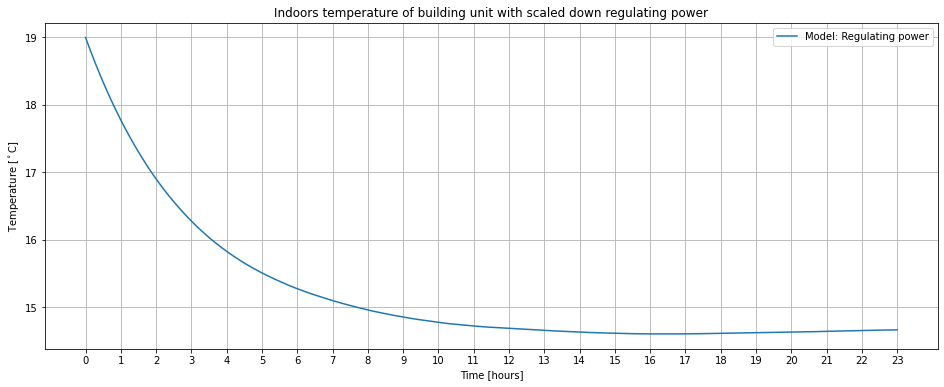

In [ ]:
from scipy.integrate import odeint

K = 273.15 # kelvin
dt = 60*60 % # 1 hour
simTime = 23*dt #simulation time
tolerance = 1e-7 #odeint tolerance

tSimArray=np.arange(0,simTime,5) # timer array, one point per 5th second

y0 =  19+K # initlai indoor temperature
Toutside = -2.2 + K #-2.2 +K
model = model(Toutside,dt = dt,simTime=simTime,)
sol = odeint(model.buildingModel, y0, tSimArray,args=(False,False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solJustPower-K, label="Model: Regulating power")
plt.xlabel('Time [hours]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit with scaled down regulating power")
plt.legend()

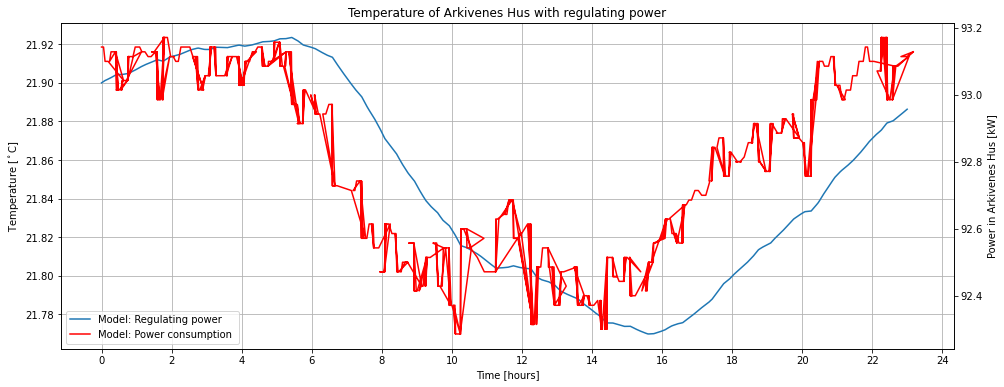

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating power")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature [$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solJustPower-K, label="Model: Regulating power")

ax2 = ax1.twinx()

PowerList = modelJustPower.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

legend2 = ax2.plot(timePowerList/3600, ValuePowerList/1000, color='red', label="Model: Power consumption ")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

## Only Outdoor temperature

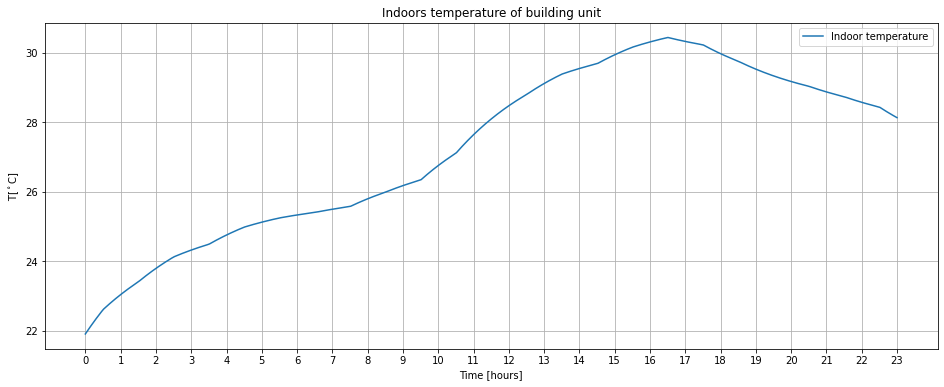

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelOutdoorTemp = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solOutdoorTemp = odeint(modelOutdoorTemp.buildingModel, y0, tSimArray,args=(True,False,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solOutdoorTemp-K, label="Indoor temperature")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

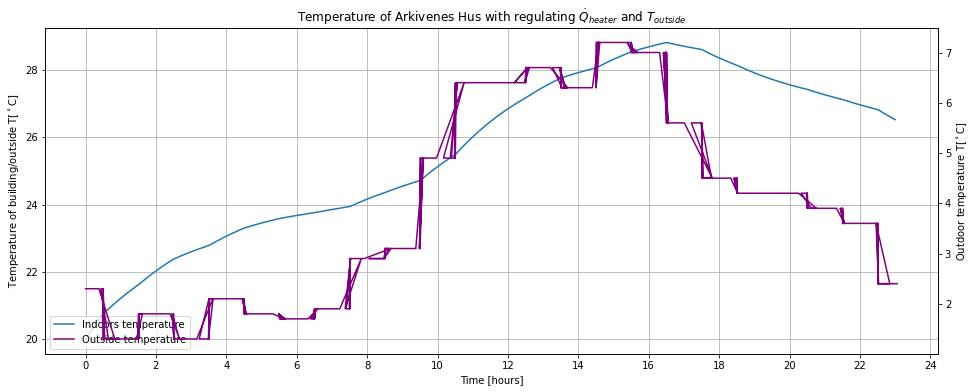

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $T_{outside}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solOutdoorTemp-K, label="Indoors temperature")

# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = modelOutdoorTemp.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
#ax4.spines['right'].set_position(('outward', 60))

lns = legend1+legend5
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

## Only People

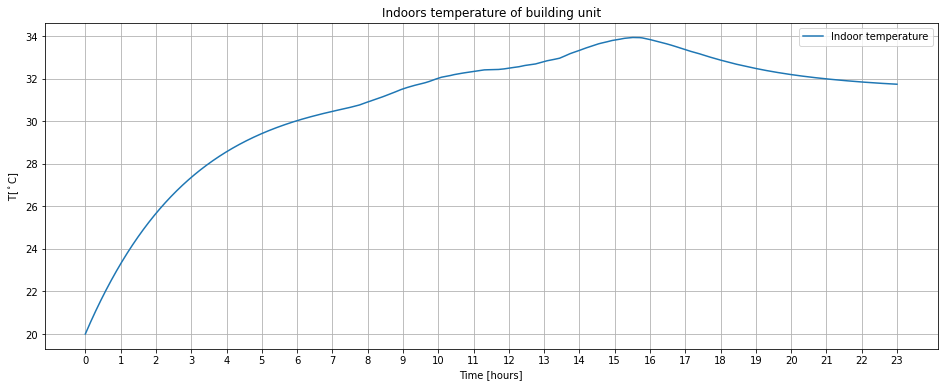

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelPeople = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfPeople2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solPeople = odeint(modelPeople.buildingModel, y0, tSimArray,args=(False,True,False,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPeople-K, label="Indoor temperature")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

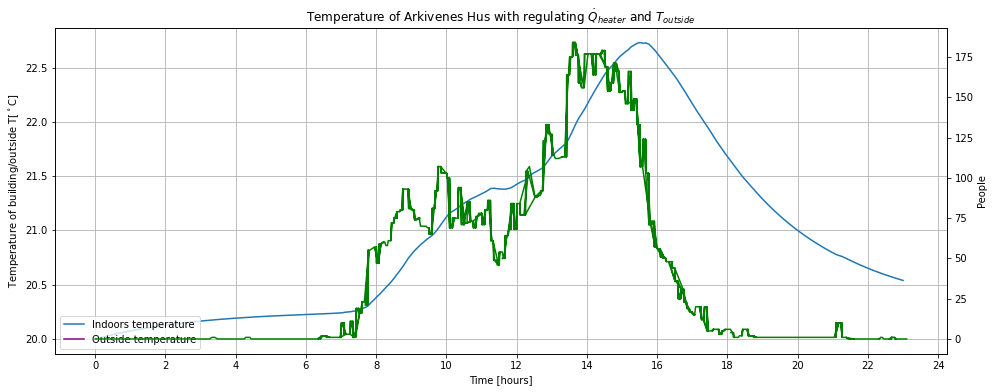

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $T_{outside}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPeople-K, label="Indoors temperature")

# People
ax3 = ax1.twinx()

ax3.set_ylabel("People")
peopleList = modelPowerNOutdoorTempNPeople.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax3.plot(timepeopleList/3600, ValuepeopleList/80, label="People inside", color="green")
#ax3.spines['right'].set_position(('outward', 120))

lns = legend1+legend5
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

## Only flow

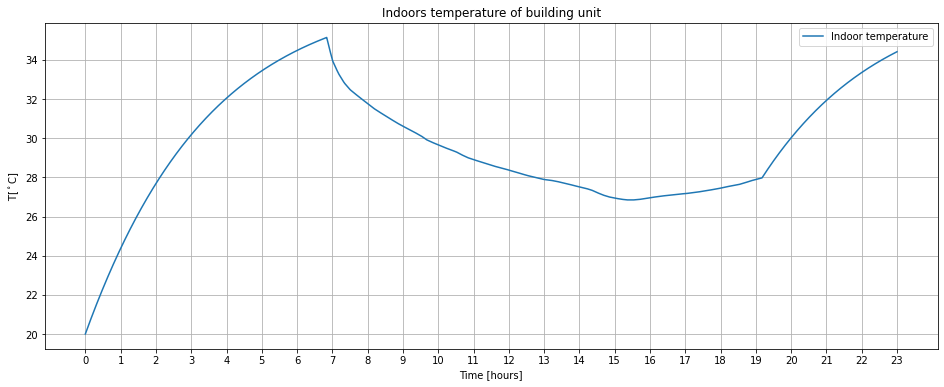

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelFlow = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfPeople2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solFlow = odeint(modelFlow.buildingModel, y0, tSimArray,args=(False,False,False,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solFlow-K, label="Indoor temperature")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

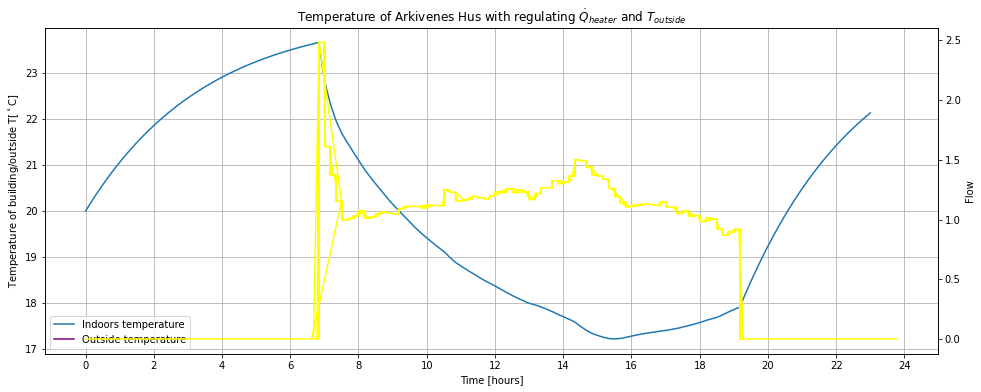

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $T_{outside}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solFlow-K, label="Indoors temperature")

# Flow
ax5 = ax1.twinx()
FlowList = modelFlow.FlowList

timeFlowList = np.array([row[0] for row in FlowList])
ValueFlowList = np.array([row[1] for row in FlowList])

legend6 = ax5.plot(timeFlowList/3600,ValueFlowList, color='yellow', label="Flow inside")
ax5.set_ylabel('Flow')

lns = legend1+legend5
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

## Comparing the "onlys"

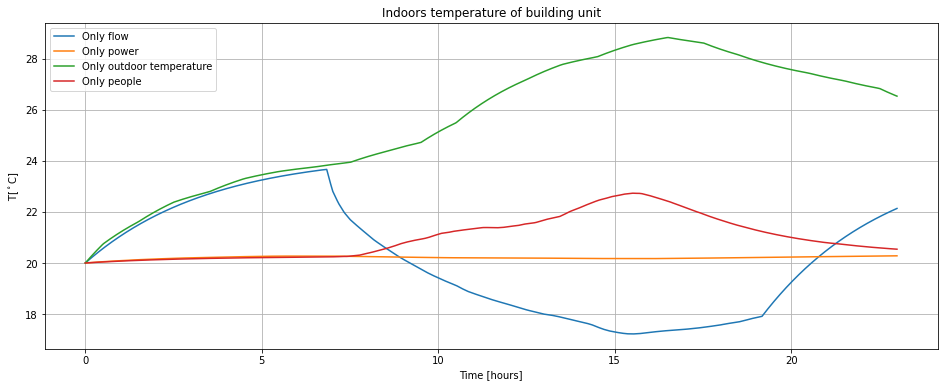

In [ ]:
fig = plt.figure(figsize=(16, 6))
plt.grid()

plt.plot(tSimArray/dt, solFlow-K, label="Only flow")
plt.plot(tSimArray/dt, solJustPower-K, label="Only power")
plt.plot(tSimArray/dt, solOutdoorTemp-K, label="Only outdoor temperature")
plt.plot(tSimArray/dt, solPeople-K, label="Only people")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

# Two data 

## Power and Outdoor temperature

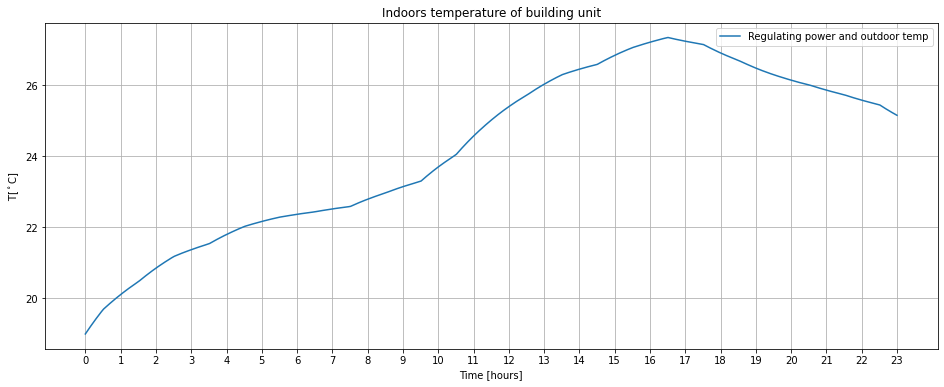

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,5)

y0 = 19+K
Toutside = -2.2 + K #-2.2 +K
modelPowerNOutdoorTemp = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, QheaterDataArray=dfPower3 )
solPowerNOutdoorTemp = odeint(modelPowerNOutdoorTemp.buildingModel, y0, tSimArray,args=(True,False,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerNOutdoorTemp-K, label="Regulating power and outdoor temp")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

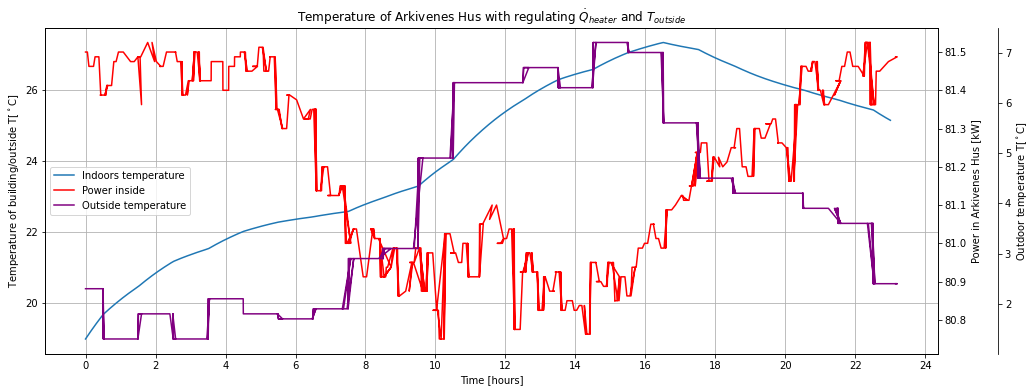

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $T_{outside}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNOutdoorTemp-K, label="Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelPowerNOutdoorTemp.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = modelPowerNOutdoorTemp.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
ax4.spines['right'].set_position(('outward', 60))

lns = legend1+legend2+legend5
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")
plt.show()

In [ ]:
solPowerNOutdoorTemp.max() - K

27.335110044798853

## Power Vs People

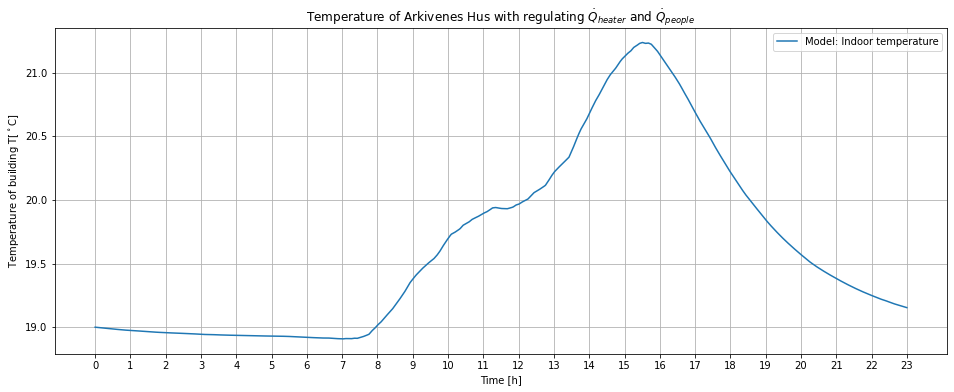

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)

dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

K = 273.15
dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,5)

y0 = 19+K
Toutside = -2.2 + K #-2.2 +K
modelPowerNPeople = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3 )
solPowerNPeople = odeint(modelPowerNPeople.buildingModel, y0, tSimArray,args=(False,True,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerNPeople-K, label="Model: Indoor temperature")
plt.xlabel('Time [h]')
plt.ylabel('Temperature of building T[$^\circ$C]')
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $\dot{Q}_{people}$")

plt.legend()

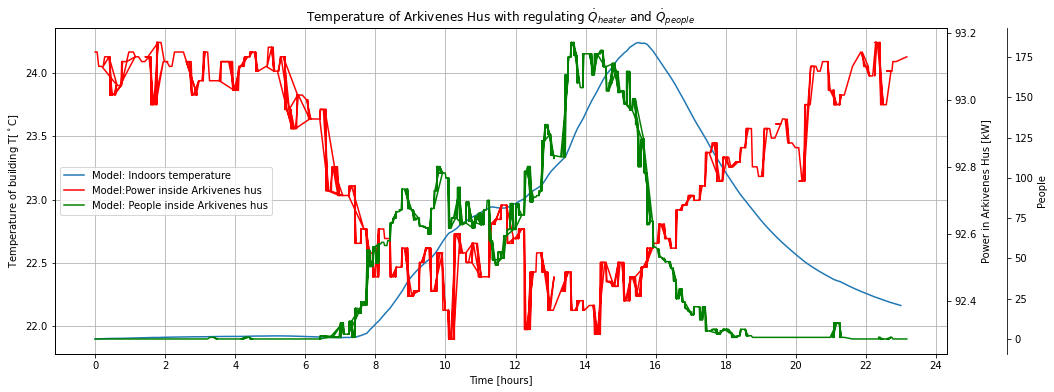

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $\dot{Q}_{people}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNPeople-K, label="Model: Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelPowerNPeople.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList/3600, ValuePowerList/1000, color='red', label="Model:Power inside Arkivenes hus")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# People
ax3 = ax1.twinx()

ax3.set_ylabel("People")
peopleList = modelPowerNPeople.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax3.plot(timepeopleList/3600, ValuepeopleList/80, label="Model: People inside Arkivenes hus", color="green")
ax3.spines['right'].set_position(('outward', 60))

lns = legend1+legend2+legend4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")
plt.show()

In [ ]:
ValuePowerList.max()

93171.42857142857

## Power vs Airflow

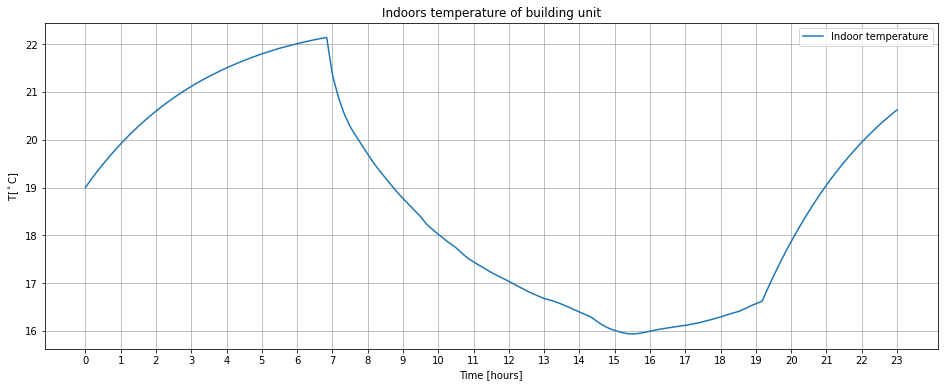

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,5)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelPowerNFlow = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solPowerNFlow = odeint(modelPowerNFlow.buildingModel, y0, tSimArray,args=(False,False,True,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerNFlow-K, label="Indoor temperature")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

In [ ]:
dfFlow.value.max()

5633.0

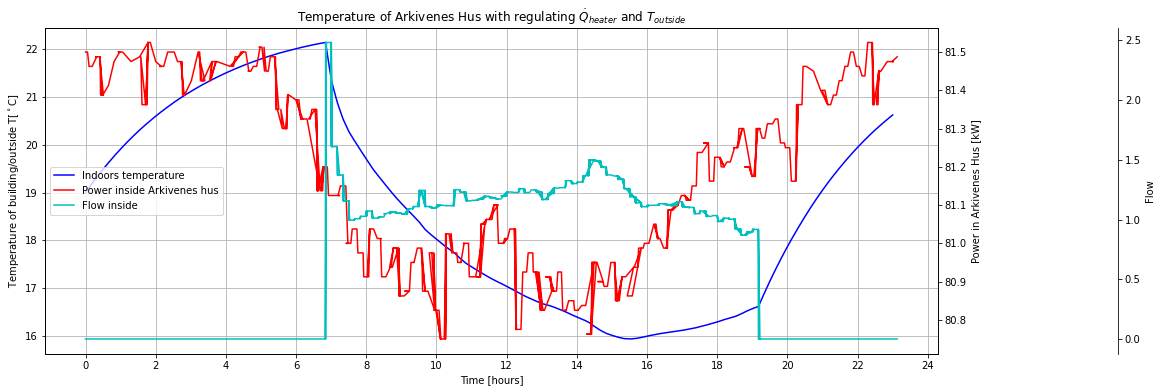

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $T_{outside}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNFlow-K, color='blue', label="Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelPowerNFlow.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList/3600, ValuePowerList/1000, color='red', label="Power inside Arkivenes hus")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# Flow
ax5 = ax1.twinx()
FlowList = modelPowerNFlow.FlowList

timeFlowList = np.array([row[0] for row in FlowList])
ValueFlowList = np.array([row[1] for row in FlowList])

# ValueFlowList2 = ValueFlowList[np.where(ValueFlowList > 0)]
# timeFlowList2 = timeFlowList[np.where(ValueFlowList > 0)]

legend6 = ax5.plot(timeFlowList/3600,ValueFlowList, color='c', label="Flow inside")
ax5.set_ylabel('Flow')
ax5.spines['right'].set_position(('outward', 180))

lns = legend1+legend2+legend6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")
plt.show()

# Four data

## People vs outside temp vs flow

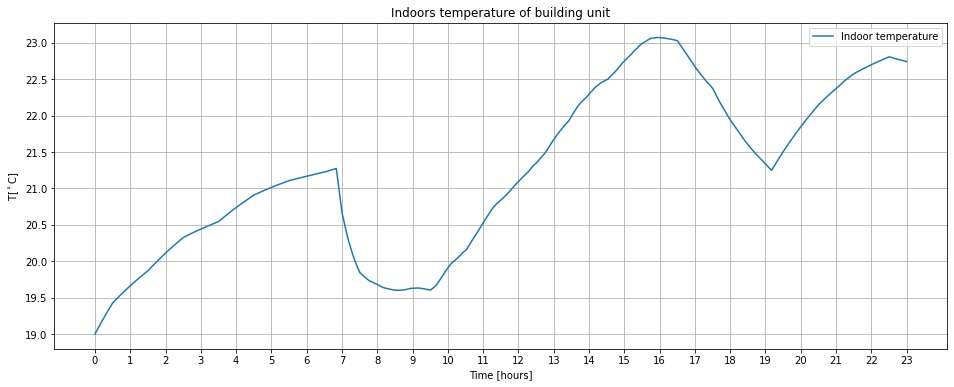

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)

dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 29.8+K
Toutside = -2.2 + K #-2.2 +K
modelAllData = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solAllData = odeint(modelAllData.buildingModel, y0, tSimArray,args=(True,True,True,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solAllData-K, label="Indoor temperature")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

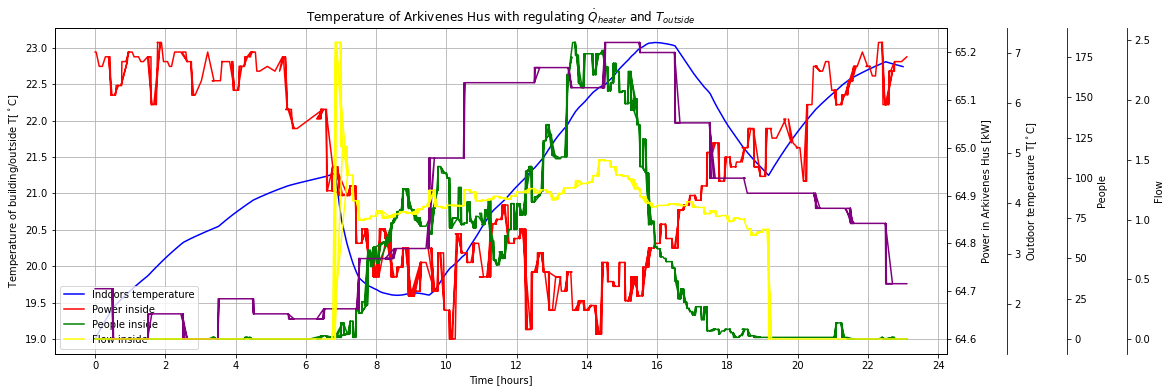

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $\dot{Q}_{heater}$ and $T_{outside}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solAllData-K, color='blue', label="Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelAllData.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# People
ax3 = ax1.twinx()

ax3.set_ylabel("People")
peopleList = modelAllData.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax3.plot(timepeopleList/3600, ValuepeopleList/80, label="People inside", color="green")
ax3.spines['right'].set_position(('outward', 120))

# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = modelAllData.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
ax4.spines['right'].set_position(('outward', 60))

# Flow
ax5 = ax1.twinx()
FlowList = modelAllData.FlowList

timeFlowList = np.array([row[0] for row in FlowList])
ValueFlowList = np.array([row[1] for row in FlowList])

# ValueFlowList2 = ValueFlowList[np.where(ValueFlowList > 0)]
# timeFlowList2 = timeFlowList[np.where(ValueFlowList > 0)]

legend6 = ax5.plot(timeFlowList/3600,ValueFlowList, color='yellow', label="Flow inside")
ax5.set_ylabel('Flow')
ax5.spines['right'].set_position(('outward', 180))

lns = legend1+legend2+legend4+legend6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

# Three data

## Power V outdoor V people

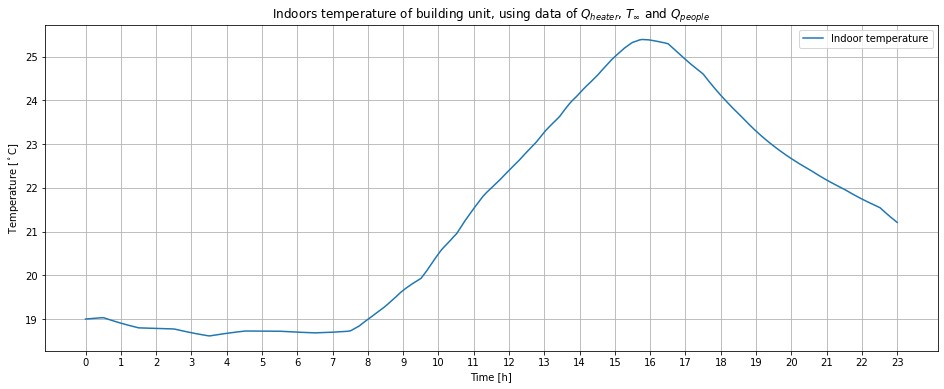

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelPowerNOutdoorNPeople = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solPowerNOutdoorNPeople = odeint(modelPowerNOutdoorNPeople.buildingModel, y0, tSimArray,args=(True,True,True,False ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerNOutdoorNPeople-K, label="Indoor temperature")
plt.xlabel('Time [h]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit, using data of $Q_{heater}$, $T_{\infty}$ and $Q_{people}$")
plt.legend()

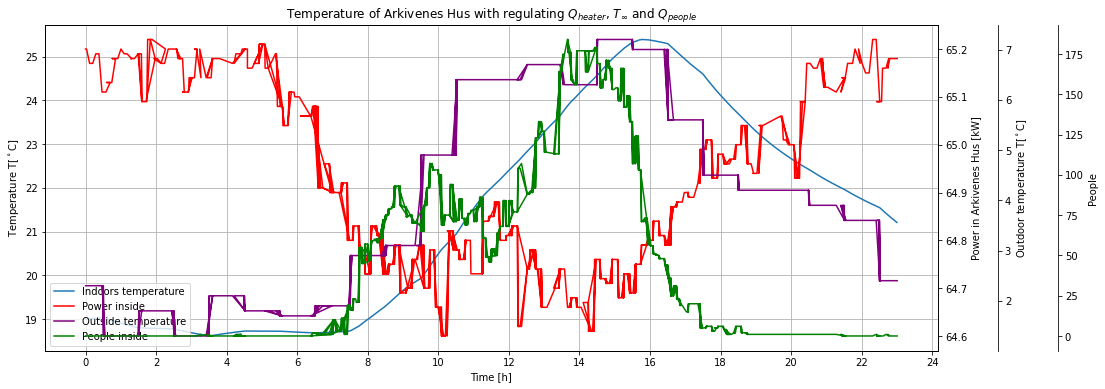

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $Q_{heater}$, $T_{\infty}$ and $Q_{people}$")

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNOutdoorNPeople-K, label="Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelPowerNOutdoorNPeople.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = modelPowerNOutdoorNPeople.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
ax4.spines['right'].set_position(('outward', 60))

# People
ax3 = ax1.twinx()

ax3.set_ylabel("People")
peopleList = modelPowerNOutdoorNPeople.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax3.plot(timepeopleList/3600, ValuepeopleList/80, label="People inside", color="green")
ax3.spines['right'].set_position(('outward', 120))

lns = legend1+legend2+legend5+legend4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

## Power V Outdoor V airflow

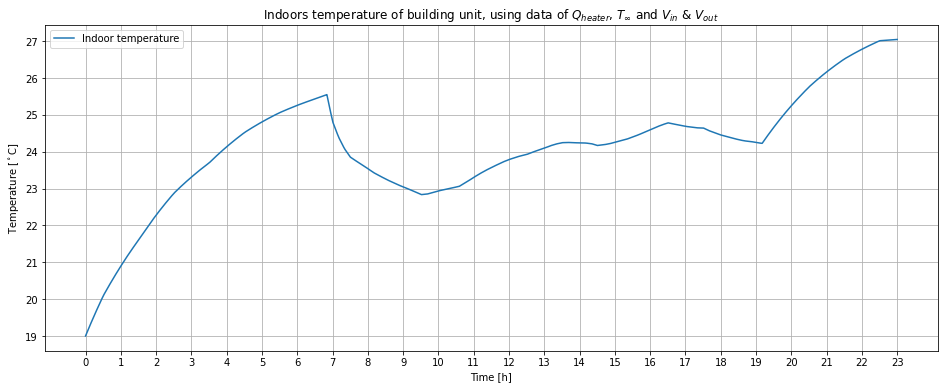

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelPowerNOutdoorNFlow = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solPowerNOutdoorNFlow = odeint(modelPowerNOutdoorNFlow.buildingModel, y0, tSimArray,args=(True,False,True,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerNOutdoorNFlow-K, label="Indoor temperature")
plt.xlabel('Time [h]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit, using data of $Q_{heater}$, $T_{\infty}$ and $V_{in}$ & $V_{out}$")
plt.legend()

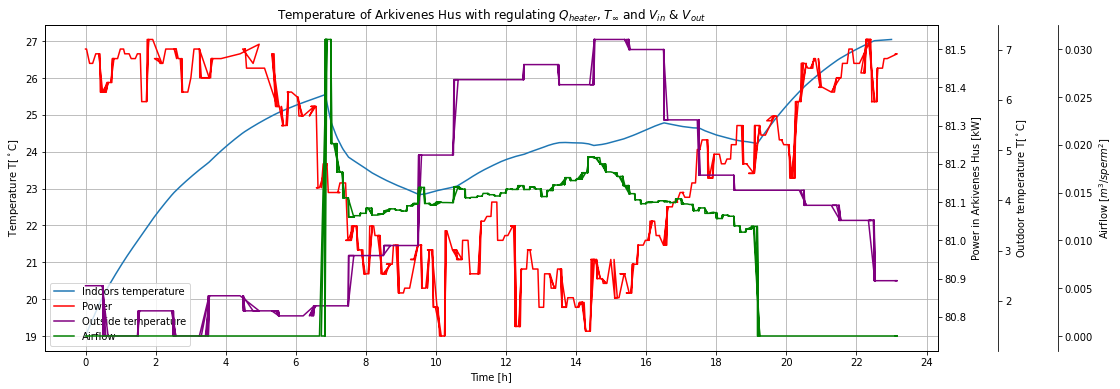

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $Q_{heater}$, $T_{\infty}$ and $V_{in}$ & $V_{out}$")
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature T[$^\circ$C]')

ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNOutdoorNFlow-K, label="Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelPowerNOutdoorNFlow.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = modelPowerNOutdoorNFlow.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
ax4.spines['right'].set_position(('outward', 60))

# Airflow
ax3 = ax1.twinx()

ax3.set_ylabel("Airflow [$m^3/s per m^2$]")
FlowList = modelPowerNOutdoorNFlow.FlowList

timeFlowList = np.array([row[0] for row in FlowList])
ValueFlowList = np.array([row[1] for row in FlowList])

legend4 = ax3.plot(timeFlowList/3600, ValueFlowList/80, label="Airflow", color="green")
ax3.spines['right'].set_position(('outward', 120))

lns = legend1+legend2+legend5+legend4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

## Power V People V airflow

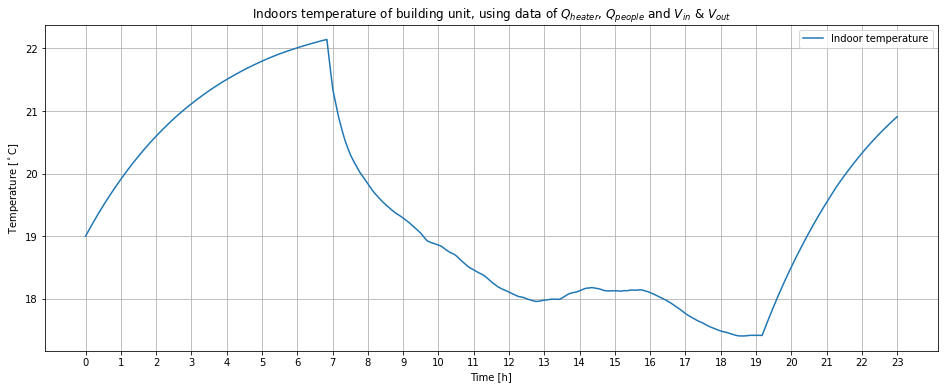

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelPowerNPeopleNFlow = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solPowerNPeopleNFlow = odeint(modelPowerNPeopleNFlow.buildingModel, y0, tSimArray,args=(False,True,True,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerNPeopleNFlow-K, label="Indoor temperature")
plt.xlabel('Time [h]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Indoors temperature of building unit, using data of $Q_{heater}$, $Q_{people}$ and $V_{in}$ & $V_{out}$")
plt.legend()

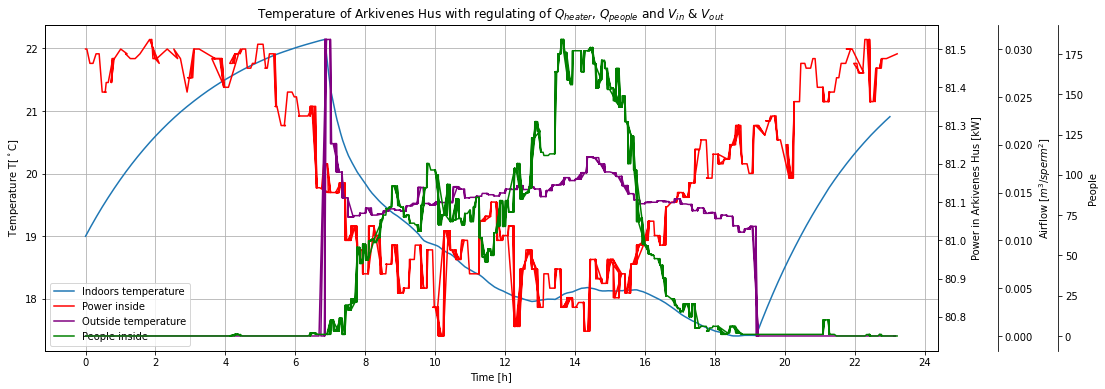

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()

plt.title("Temperature of Arkivenes Hus with regulating of $Q_{heater}$, $Q_{people}$ and $V_{in}$ & $V_{out}$")
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNPeopleNFlow-K, label="Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelPowerNPeopleNFlow.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# Airflow
ax3 = ax1.twinx()

ax3.set_ylabel("Airflow [$m^3/s per m^2$]")
FlowList = modelPowerNOutdoorNFlow.FlowList

timeFlowList = np.array([row[0] for row in FlowList])
ValueFlowList = np.array([row[1] for row in FlowList])

legend4 = ax3.plot(timeFlowList/3600, ValueFlowList/80, label="Airflow", color="purple")
ax3.spines['right'].set_position(('outward', 60))


# People
ax4 = ax1.twinx()

ax4.set_ylabel("People")
peopleList = modelPowerNPeopleNFlow.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax4.plot(timepeopleList/3600, ValuepeopleList/80, label="People inside", color="green")
ax4.spines['right'].set_position(('outward', 120))

lns = legend1+legend2+legend5+legend4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

## Compare three datas

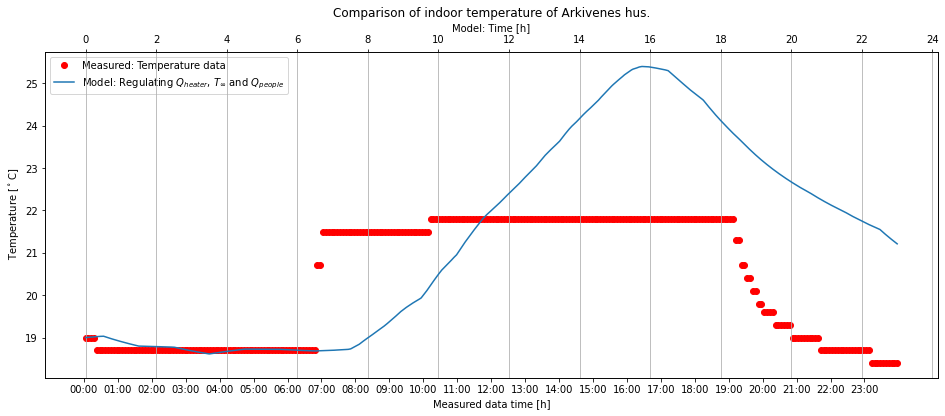

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)

plt.title("Comparison of indoor temperature of Arkivenes hus.")
pd.plotting.register_matplotlib_converters()

# NORCE data plot
legend1=ax1.plot(dfTemp.time, dfTemp.value, 'ro', label="Measured: Temperature data")
ax1.set_xticks(idxTemp)
ax1.set_xlabel("Measured data time [h]")
ax1.set_ylabel(" Temperature [$^\circ$C]")

# Our model plots
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,24+1,2))
ax2.set_xlabel("Numerical simulation hour")

#legend5 = ax2.plot(tSimArray/dt, solPowerNPeopleNFlow-K, label="Model: Regulating $Q_{heater}$, $Q_{people}$ and $V_{in}$ & $V_{out}$")
#legend6 = ax2.plot(tSimArray/dt, solPowerNOutdoorNFlow-K, label="Model: Regulating $Q_{heater}$, $T_{\infty}$ and $V_{in}$ & $V_{out}$")
legend7 = ax2.plot(tSimArray/dt, solPowerNOutdoorNPeople-K, label="Model: Regulating $Q_{heater}$, $T_{\infty}$ and $Q_{people}$")
ax2.set_xlabel('Model: Time [h]')
lns = legend1+legend7#+legend6+legend5 
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper left")

plt.grid()
plt.show()






# Solar power

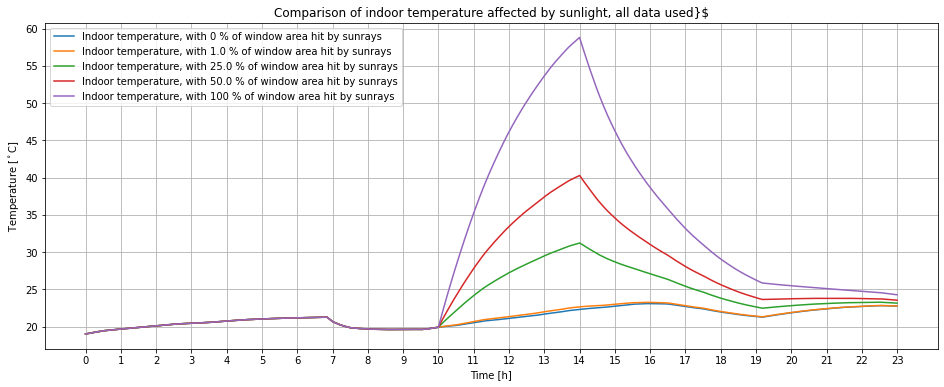

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)
solarPower = [0,0.01,0.25,0.5,1]

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))
#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K

for i in solarPower:

  modelPowerNOutdoorNPeople = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
  solPowerNOutdoorNPeople = odeint(modelPowerNOutdoorNPeople.buildingModel, y0, tSimArray,args=(True,True,True,True, True, i ),  rtol=tolerance,atol=tolerance) 


  plt.plot(tSimArray/dt, solPowerNOutdoorNPeople-K, label="Indoor temperature, with {} % of window area hit by sunrays".format(i*100))
plt.xlabel('Time [h]')
plt.ylabel('Temperature [$^\circ$C]')
plt.title("Comparison of indoor temperature affected by sunlight, all data used}$")
plt.legend()

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $Q_{heater}$, $T_{\infty}$ and $Q_{people}$")

ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Temperature T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNOutdoorNPeople-K, label="Indoors temperature")

# Power
ax2 = ax1.twinx()

PowerList = modelPowerNOutdoorNPeople.PowerList
timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

ValuePowerList2 = ValuePowerList[np.where(ValuePowerList > 0)]
timePowerList2 = timePowerList[np.where(ValuePowerList > 0)]

legend2 = ax2.plot(timePowerList2/3600, ValuePowerList2/1000, color='red', label="Power inside")
ax2.set_ylabel('Power in Arkivenes Hus [kW]')

# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = modelPowerNOutdoorNPeople.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
ax4.spines['right'].set_position(('outward', 60))

# People
ax3 = ax1.twinx()

ax3.set_ylabel("People")
peopleList = modelPowerNOutdoorNPeople.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax3.plot(timepeopleList/3600, ValuepeopleList/80, label="People inside", color="green")
ax3.spines['right'].set_position(('outward', 120))

lns = legend1+legend2+legend5+legend4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
plt.show()

# Disabling power

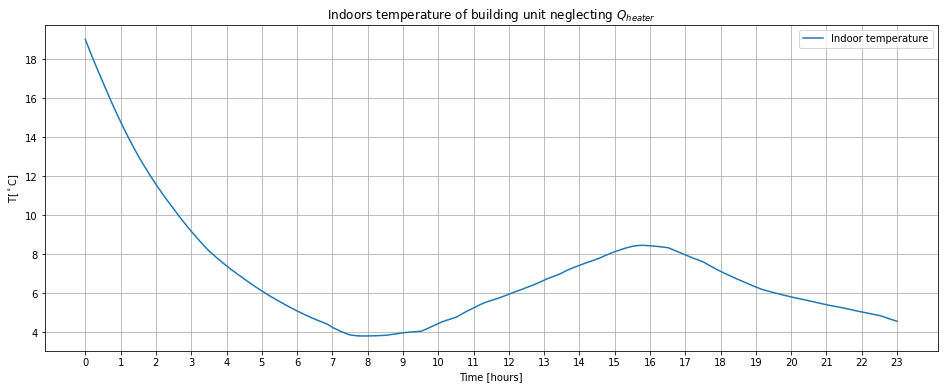

In [ ]:
from scipy.integrate import odeint
import time
from datetime import datetime, timedelta

dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfFlow2['time'] = dfFlow2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfPower3['time'] = dfPower3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['time'] = dfOutdoorTemp2['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)
dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)
dfPeople3['time'] = dfPeople3['time'].apply(lambda x: x.hour*3600 + x.minute * 60 + x.second)


dt = 60*60
simTime = 23*dt
tolerance = 1e-7

tSimArray=np.arange(0,simTime,1)

#y0 = 23.25+K
Toutside = -2.2 + K #-2.2 +K
modelPowerNOutdoorNPeopleNFlow = model(Toutside,dt = dt,simTime=simTime,OutsideDataArray=dfOutdoorTemp2, peopleDataArray=dfPeople3, QheaterDataArray=dfPower3, QflowDataArray=dfFlow2  )
solPowerNOutdoorNPeopleNFlow = odeint(modelPowerNOutdoorNPeopleNFlow.buildingModel, y0, tSimArray,args=(True,True,False,True ),  rtol=tolerance,atol=tolerance) 

fig = plt.figure(figsize=(16, 6))
plt.grid()
plt.xticks(np.arange(0,24,1))

plt.plot(tSimArray/dt, solPowerNOutdoorNPeopleNFlow-K, label="Indoor temperature")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit neglecting $Q_{heater}$")
plt.legend()

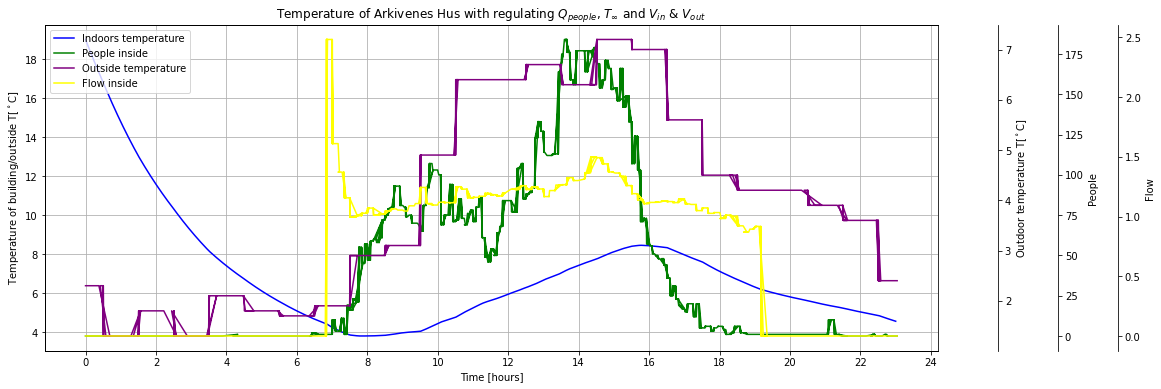

In [ ]:
# Constant vs Varying with outside temp plot
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
plt.grid()
plt.title("Temperature of Arkivenes Hus with regulating $Q_{people}$, $T_{\infty}$ and $V_{in}$ & $V_{out}$")

ax1.set_xlabel('Time [hours]')
ax1.set_ylabel('Temperature of building/outside T[$^\circ$C]')
ax1.set_xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
legend1 = ax1.plot(tSimArray/dt, solPowerNOutdoorNPeopleNFlow-K, color='blue', label="Indoors temperature")

# People
ax3 = ax1.twinx()

ax3.set_ylabel("People")
peopleList = modelPowerNOutdoorNPeopleNFlow.QpeopleList

timepeopleList = np.array([row[0] for row in peopleList])
ValuepeopleList = np.array([row[1] for row in peopleList])

legend4 = ax3.plot(timepeopleList/3600, ValuepeopleList/80, label="People inside", color="green")
ax3.spines['right'].set_position(('outward', 120))

# Outside temperature
ax4 = ax1.twinx()
ax4.set_ylabel("Outdoor temperature T[$^\circ$C]")
OutsidetempList = modelPowerNOutdoorNPeopleNFlow.ToutLst

timeOutsidetempList = np.array([row[0] for row in OutsidetempList])
ValueOutsidetempList = np.array([row[1] for row in OutsidetempList])

legend5 = ax4.plot(timeOutsidetempList/3600, ValueOutsidetempList-K, label="Outside temperature", color="purple")
ax4.spines['right'].set_position(('outward', 60))

# Flow
ax5 = ax1.twinx()
FlowList = modelPowerNOutdoorNPeopleNFlow.FlowList

timeFlowList = np.array([row[0] for row in FlowList])
ValueFlowList = np.array([row[1] for row in FlowList])

legend6 = ax5.plot(timeFlowList/3600,ValueFlowList, color='yellow', label="Flow inside")
ax5.set_ylabel('Flow')
ax5.spines['right'].set_position(('outward', 180))

lns = legend1+legend4+legend5+legend6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="upper left")
plt.show()

# Combining all plots

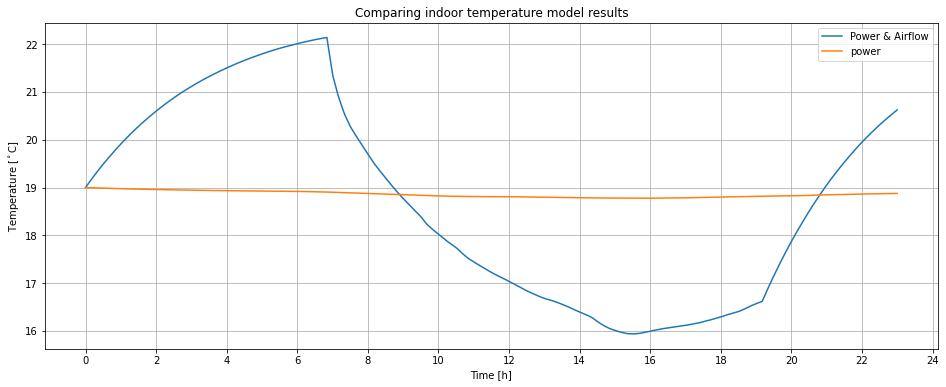

In [ ]:
fig = plt.figure(figsize=(16, 6))
plt.grid()

plt.xticks(np.arange((min(tSimArray)/dt),(max(tSimArray)/dt)+2,2))
#plt.plot(tSimArray/dt, solPowerNOutdoorNPeopleNFlow-K, label="Power & Outdoor temp & People & Airflow")
#plt.plot(tSimArray/dt, solPowerNOutdoorTempNPeople-K, label="Power & Outdoor temp & People")
#plt.plot(tSimArray/dt, solPowerNOutdoorTemp-K, label="Power & Outdoor temp")
plt.plot(tSimArray/dt, solPowerNFlow-K, label="Power & Airflow")
# plt.plot(tSimArray/dt, solPowerNPeople-K, label="Power & People")
plt.plot(tSimArray/dt, solJustPower-K, label="power")
plt.xlabel('Time [h]')
plt.ylabel("Temperature [$^\circ$C]")
plt.title("Comparing indoor temperature model results")
plt.legend()

# Compare simulations with NORCE data

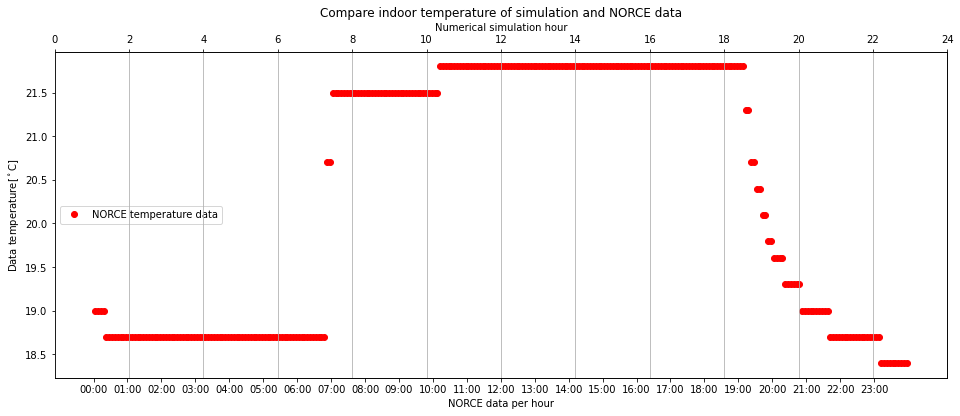

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)

plt.title("Compare indoor temperature of simulation and NORCE data")


dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')
#ax1.set_xticks(idxTemp)
pd.plotting.register_matplotlib_converters()

# NORCE data plot
legend1=ax1.plot(dfTemp.time, dfTemp.value, 'ro', label="NORCE temperature data")
ax1.set_xticks(idxTemp)
ax1.set_xlabel("NORCE data per hour")
ax1.set_ylabel("Data temperature[$^\circ$C]")

# Our model plots
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,24+1,2))
ax2.set_xlabel("Numerical simulation hour")
# legend2 = ax2.plot(tSimArray/dt, solPowerNOutdoorNPeopleNFlow-K, label="Model: Power & Outdoor temp & People & Airflow")
# # legend3 = ax2.plot(tSimArray/dt, solPowerNOutdoorTempNPeople-K, label="Model: Power & Outdoor temp & People")
# legend7 = ax2.plot(tSimArray/dt, solPowerNFlow-K, label="Model: Power & Airflow")
# # legend4 = ax2.plot(tSimArray/dt, solPowerNOutdoorTemp-K, label="Model: Power & Outdoor temp")
# # legend5 = ax2.plot(tSimArray/dt, solPowerNPeople-K, label="Model: Power & People")
# legend6 = ax2.plot(tSimArray/dt, solJustPower-K, label="Model: Power")


lns = legend1#+legend6+legend7 #legend2+legend3+legend4+
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")

plt.grid()
plt.show()

In [ ]:
dfTemp.value[1950]

21.5

# Compare measured data with simulated data

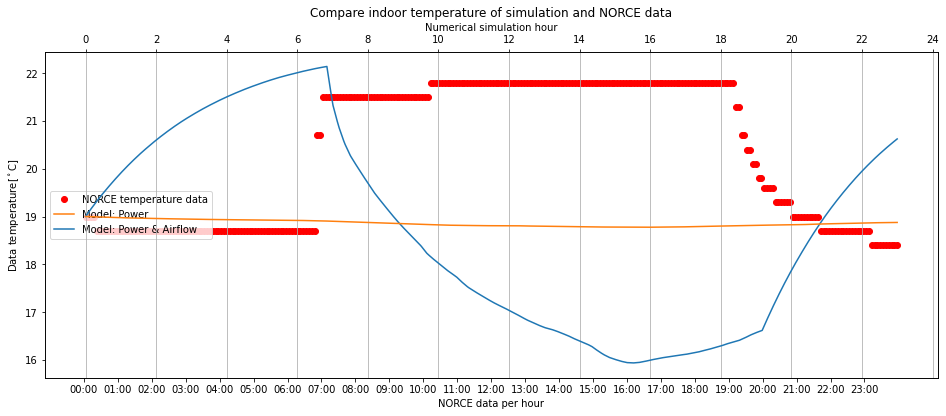

In [ ]:
import pandas as pd
import datetime

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)

plt.title("Compare indoor temperature of simulation and NORCE data")


dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')
dfPower3 = dfPower2.copy()
dfOutdoorTemp2 = dfOutdoorTemp.copy()
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
dfFlow2 = dfFlow.copy()

K = 273.15

dfOutdoorTemp2['value'] = dfOutdoorTemp2['value'].apply(lambda y: y + K)

pd.plotting.register_matplotlib_converters()

# NORCE data plot
legend1=ax1.plot(dfTemp.time, dfTemp.value, 'ro', label="NORCE temperature data")
ax1.set_xticks(idxTemp)
ax1.set_xlabel("NORCE data per hour")
ax1.set_ylabel("Data temperature[$^\circ$C]")

# Our model plots
ax2 = ax1.twiny()
ax2.set_xticks(np.arange(0,24+1,2))
ax2.set_xlabel("Numerical simulation hour")
# legend2 = ax2.plot(tSimArray/dt, solPowerNOutdoorNPeopleNFlow-K, label="Model: Power & Outdoor temp & People & Airflow")
# legend3 = ax2.plot(tSimArray/dt, solPowerNOutdoorTempNPeople-K, label="Model: Power & Outdoor temp & People")
legend7 = ax2.plot(tSimArray/dt, solPowerNFlow-K, label="Model: Power & Airflow")
# legend4 = ax2.plot(tSimArray/dt, solPowerNOutdoorTemp-K, label="Model: Power & Outdoor temp")
# legend5 = ax2.plot(tSimArray/dt, solPowerNPeople-K, label="Model: Power & People")
legend6 = ax2.plot(tSimArray/dt, solJustPower-K, label="Model: Power")


lns = legend1+legend6+legend7 #legend2+legend3+legend4+
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")

plt.grid()
plt.show()

## Power

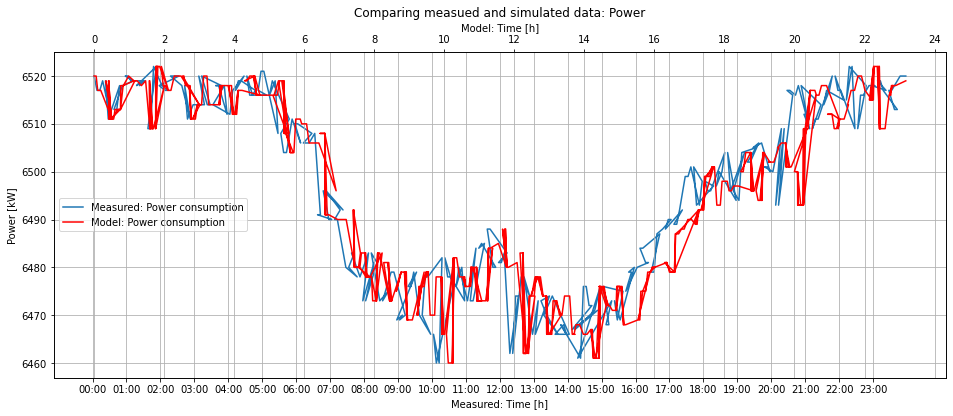

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(111)
plt.grid()
plt.title("Comparing measued and simulated data: Power")

# Measured data
dfPower3 = dfPower2.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Power [kW]')

dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPower3.time, dfPower3.value, label="Measured: Power consumption")
ax1.set_xticks(idxTemp)
# Simulated data
ax2 = ax1.twiny()
PowerList = modelJustPower.PowerList

timePowerList = np.array([row[0] for row in PowerList])
ValuePowerList = np.array([row[1] for row in PowerList])

legend2 = ax2.plot(timePowerList/3600, (ValuePowerList*80)/1000, color='red', label="Model: Power consumption ")
ax2.set_xlabel('Model: Time [h]')
ax2.set_xticks(np.arange(0,24+1,2))
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")

plt.grid()
plt.show()

In [ ]:
idxTemp

Index(['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00',
       '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00',
       '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00',
       '00:00', '01:00'],
      dtype='object')

## Outdoor temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


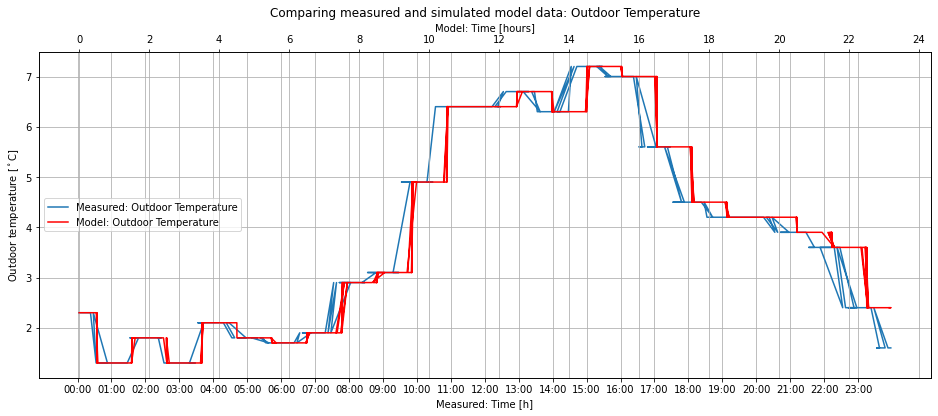

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
plt.grid()
plt.title("Comparing measured and simulated model data: Outdoor Temperature")

# Measured data
dfOutdoorTemp2 = dfOutdoorTemp.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Outdoor temperature [$^\circ$C]')

dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfOutdoorTemp2.time, dfOutdoorTemp2.value , label="Measured: Outdoor Temperature")
ax1.set_xticks(idxTemp)
# Simulated data
ax2 = ax1.twiny()
OutdoorList = modelPowerNOutdoorTemp.ToutLst

timeOutdoorList = np.array([row[0] for row in OutdoorList])
ValueOutdoorList = np.array([row[1] for row in OutdoorList])

legend2 = ax2.plot(timeOutdoorList/3600, ValueOutdoorList -K, color='red', label="Model: Outdoor Temperature")
ax2.set_xlabel('Model: Time [hours]')
ax2.set_xticks(np.arange(0,24+1,2))
lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")

plt.grid()
plt.show()

## People

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


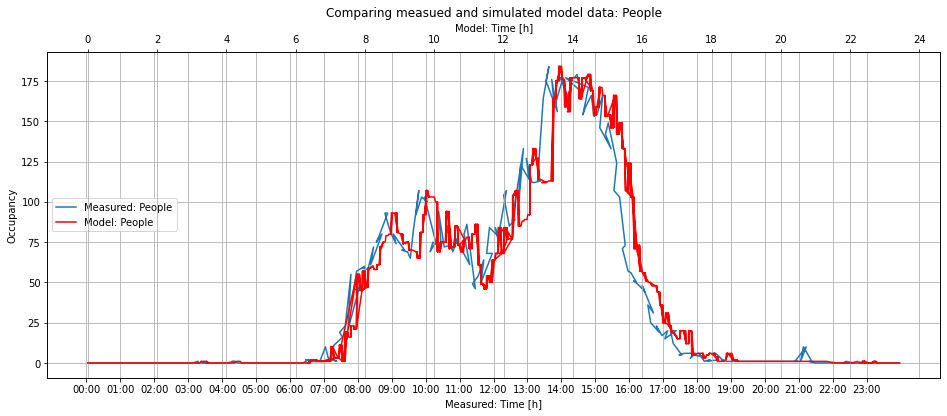

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
plt.grid()
plt.title("Comparing measued and simulated model data: People")

# Measured data
dfPeople3 = dfPeople1.copy()
dfPeople3.value = dfPeople1.value + dfPeople2.value
dfPeople3 = dfPeople3.fillna(0)
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Occupancy')

dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')


legend1 = ax1.plot(dfPeople3.time, dfPeople3.value, label="Measured: People")
ax1.set_xticks(idxTemp)
# Simulated data
ax2 = ax1.twiny()
PowerNPeopleList = modelPowerNPeople.QpeopleList

timePowerNPeopleList = np.array([row[0] for row in PowerNPeopleList])
ValuePowerNPeopleList = np.array([row[1] for row in PowerNPeopleList])

legend2 = ax2.plot(timePowerNPeopleList/3600, ValuePowerNPeopleList/80, color='red', label="Model: People")
ax2.set_xlabel('Model: Time [h]')
ax2.set_xticks(np.arange(0,24+1,2))

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")

plt.grid()
plt.show()

## Air-flow

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


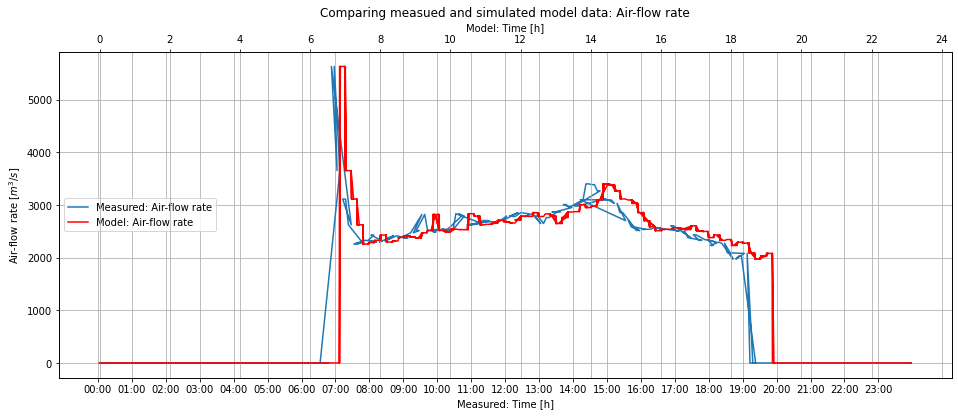

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
plt.grid()
plt.title("Comparing measued and simulated model data: Air-flow rate")

# Measured data
dfFlow2 = dfFlow.copy()
pd.plotting.register_matplotlib_converters()
ax1.set_xlabel('Measured: Time [h]')
ax1.set_ylabel('Air-flow rate [$m^3/s$]')

#dfTemp, idxTemp = convertTime('/content/drive/MyDrive/UiS/1 Master Thesis/data/extract_temp_2.csv')

legend1 = ax1.plot(dfFlow2.time, dfFlow2.value, label="Measured: Air-flow rate")
ax1.set_xticks(idxTemp)

# Simulated data
ax2 = ax1.twiny()
PowerNFlowList = modelPowerNFlow.FlowList

timePowerNFlowList = np.array([row[0] for row in PowerNFlowList])
ValuePowerNFlowList = np.array([row[1] for row in PowerNFlowList])

legend2 = ax2.plot(timePowerNFlowList/3600, ValuePowerNFlowList * modelPowerNFlow.Afloor, color='red', label="Model: Air-flow rate ")
ax2.set_xlabel('Model: Time [h]')
ax2.set_xticks(np.arange(0,24+1,2))

lns = legend1+legend2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center left")

plt.grid()
plt.show()